In [1]:
%matplotlib inline

In [2]:
from IPython.display import HTML

In [3]:
from matplotlib import pyplot as plt
from matplotlib.animation import ArtistAnimation
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import pymc3 as pm
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import seaborn as sns
import tensorflow as tf
from theano import shared, tensor as tt

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [7]:
SEED = 69972 # from random.org, for reproducibility

np.random.seed(SEED)

In [8]:
blue, green, red, purple, gold, teal = sns.color_palette()

In [9]:
x_beta_binomial = np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [23]:
help(sp.special.expit)

Help on ufunc object:

expit = class ufunc(builtins.object)
 |  Functions that operate element by element on whole arrays.
 |  
 |  To see the documentation for a specific ufunc, use np.info().  For
 |  example, np.info(np.sin).  Because ufuncs are written in C
 |  (for speed) and linked into Python with NumPy's ufunc facility,
 |  Python's help() function finds this page whenever help() is called
 |  on a ufunc.
 |  
 |  A detailed explanation of ufuncs can be found in the "ufuncs.rst"
 |  file in the NumPy reference guide.
 |  
 |  Unary ufuncs:
 |  =============
 |  
 |  op(X, out=None)
 |  Apply op to X elementwise
 |  
 |  Parameters
 |  ----------
 |  X : array_like
 |      Input array.
 |  out : array_like
 |      An array to store the output. Must be the same shape as `X`.
 |  
 |  Returns
 |  -------
 |  r : array_like
 |      `r` will have the same shape as `X`; if out is provided, `r`
 |      will be equal to out.
 |  
 |  Binary ufuncs:
 |  ==============
 |  
 |  op(X, Y, 

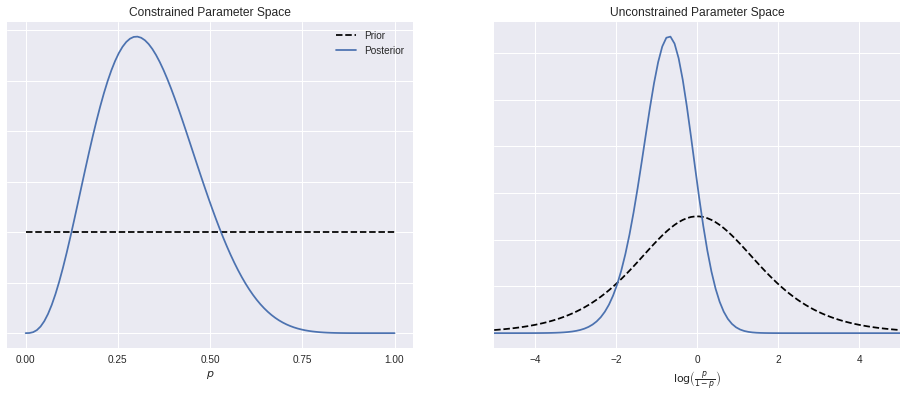

In [10]:
# plot the transformed (unconstrained) parameters
fig, (const_ax, trans_ax) = plt.subplots(ncols=2, figsize=(16, 6))

prior = sp.stats.uniform(0, 1)
posterior = sp.stats.beta(1 + x_beta_binomial.sum(),
                          1 + (1 - x_beta_binomial).sum())

# constrained distribution plots
const_x = np.linspace(0, 1, 100)
const_ax.plot(const_x, prior.pdf(const_x), '--', c='k', label='Prior');

def logit_trans_pdf(pdf, x):
    x_logit = sp.special.logit(x)
    return pdf(x_logit) / (x * (1 - x))

const_ax.plot(const_x, posterior.pdf(const_x),
              c=blue, label='Posterior');

const_ax.set_xticks(np.linspace(0, 1, 5));
const_ax.set_xlabel(r'$p$');
const_ax.set_yticklabels([]);
const_ax.set_title('Constrained Parameter Space');
const_ax.legend(loc=1);

# unconstrained distribution plots
def expit_trans_pdf(pdf, x):
    x_expit = sp.special.expit(x)
    return pdf(x_expit) * x_expit * (1 - x_expit)

trans_x = np.linspace(-5, 5, 100)
trans_ax.plot(trans_x, expit_trans_pdf(prior.pdf, trans_x), '--', c='k');
trans_ax.plot(trans_x, expit_trans_pdf(posterior.pdf, trans_x), c=blue);

trans_ax.set_xlim(trans_x.min(), trans_x.max());
trans_ax.set_xlabel(r'$\log\left(\frac{p}{1 - p}\right)$');
trans_ax.set_yticklabels([]);
trans_ax.set_title('Unconstrained Parameter Space');

In [12]:
import pymc3 as pm

with pm.Model() as beta_binomial_model:
    p_beta_binomial = pm.Uniform('p', 0., 1.)

In [13]:
with beta_binomial_model:
    x_obs = pm.Bernoulli('y', p_beta_binomial,
                         observed=x_beta_binomial)

In [14]:
%%time
with beta_binomial_model:
    advi_fit = pm.advi(n=20000, random_seed=SEED)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  
Average ELBO = -7.1888: 100%|██████████| 20000/20000 [00:00<00:00, 21862.31it/s]
Finished [100%]: Average ELBO = -7.199


CPU times: user 2 s, sys: 350 ms, total: 2.35 s
Wall time: 12.8 s


In [24]:
advi_fit

ADVIFit(means={'p_interval__': array(-0.749979598645609)}, stds={'p_interval__': 0.69059603037782868}, elbo_vals=array([-6.42679309, -6.96891512, -7.68818008, ..., -7.53106678,
       -6.61197681, -6.61590823]))

In [17]:
advi_bb_mu = advi_fit.means['p_interval__']
advi_bb_std = advi_fit.stds['p_interval__']
advi_bb_dist = sp.stats.norm(advi_bb_mu, advi_bb_std)

In [18]:
# plot the ADVI gaussian approximation to the unconstrained posterior
trans_ax.plot(trans_x, advi_bb_dist.pdf(trans_x),
              c=red, label='Variational approximation');

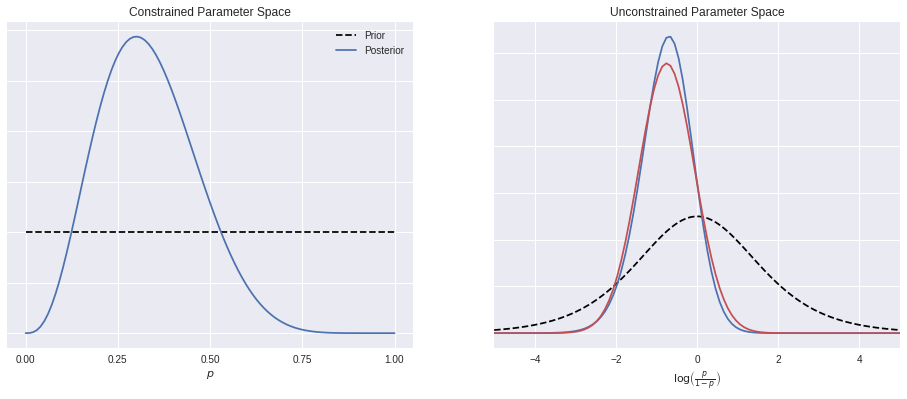

In [19]:
fig

In [20]:
# plot the ADVI approximation to the true posterior
const_ax.plot(const_x, logit_trans_pdf(advi_bb_dist.pdf, const_x),
              c=red, label='Variational approximation');

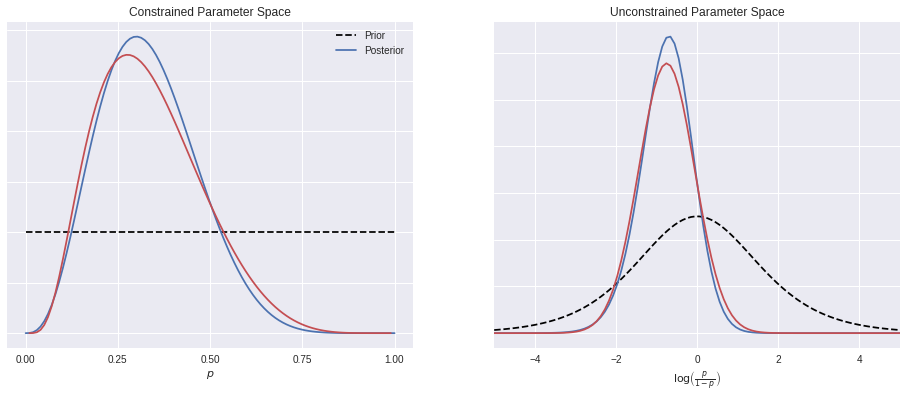

In [21]:
fig